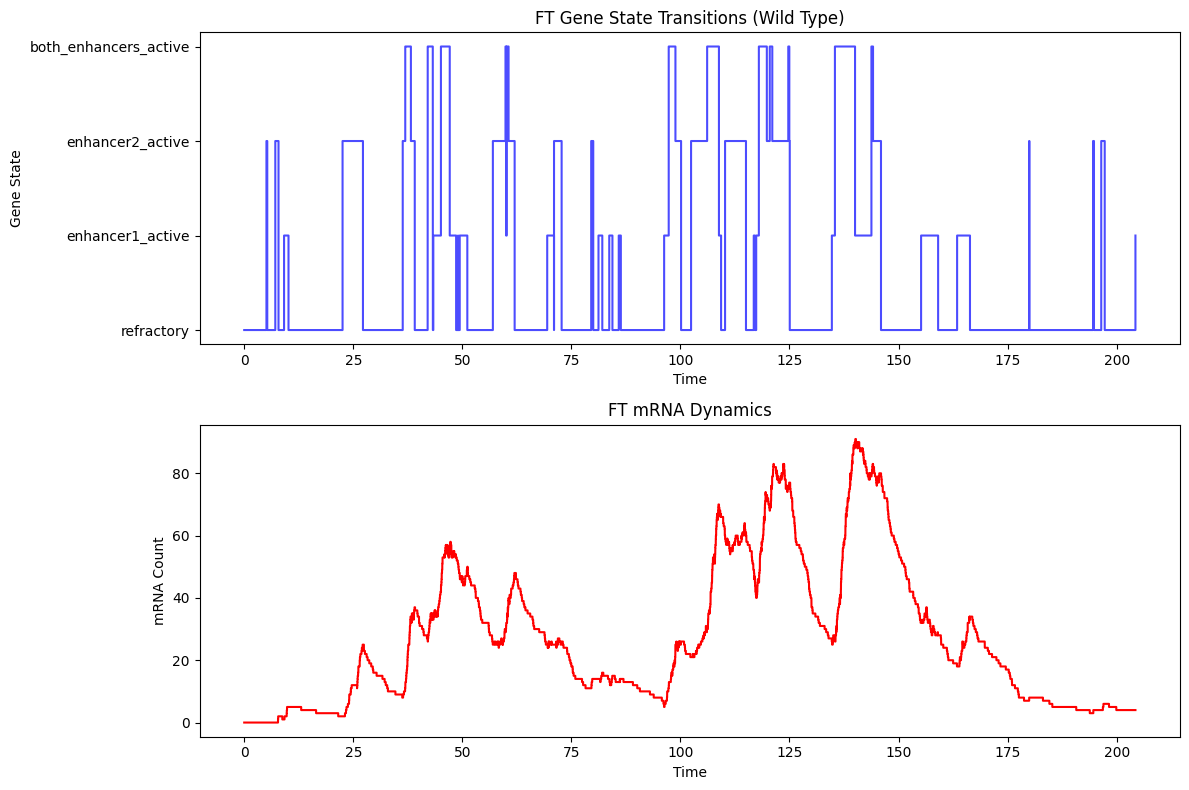

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_propensities(current_state, mRNA_count, rates, states):

    propensities = []
    reaction_descriptions = []

    # State transitions based on current gene state
    if current_state == states['refractory']:
        propensities.extend([
            rates['refractory_to_enh1'],
            rates['refractory_to_enh2']
        ])
        reaction_descriptions.extend(['refractory→enh1', 'refractory→enh2'])

    elif current_state == states['enhancer1_active']:
        propensities.extend([
            rates['enh1_to_refractory'],
            rates['enh1_to_both']
        ])
        reaction_descriptions.extend(['enh1→refractory', 'enh1→both'])

    elif current_state == states['enhancer2_active']:
        propensities.extend([
            rates['enh2_to_refractory'],
            rates['enh2_to_both']
        ])
        reaction_descriptions.extend(['enh2→refractory', 'enh2→both'])

    elif current_state == states['both_enhancers_active']:
        propensities.extend([
            rates['both_to_enh1'],
            rates['both_to_enh2'],
            rates['both_to_refractory']
        ])
        reaction_descriptions.extend(['both→enh1', 'both→enh2', 'both→refractory'])

    # Transcription reactions
    transcription_rates = {
        states['refractory']: 0.0,
        states['enhancer1_active']: rates['transcription_enh1'],
        states['enhancer2_active']: rates['transcription_enh2'],
        states['both_enhancers_active']: rates['transcription_both']
    }

    propensities.append(transcription_rates[current_state])
    reaction_descriptions.append('transcription')

    # mRNA degradation
    propensities.append(rates['mRNA_degradation'] * mRNA_count)
    reaction_descriptions.append('mRNA_degradation')

    return propensities, reaction_descriptions

def gillespie_simulation(rates, states, simulation_time):

    # Initial conditions
    current_state = states['refractory']
    mRNA_count = 0
    time = 0

    # Store results
    time_points = [time]
    state_history = [current_state]
    mRNA_history = [mRNA_count]

    while time < simulation_time:
        # Calculate all reaction probabilities
        propensities, reactions = calculate_propensities(current_state, mRNA_count, rates, states)
        total_rate = sum(propensities)

        if total_rate == 0:
            break  # No reactions possible

        # Calculate time until next reaction
        r1 = np.random.rand()
        dt = -np.log(r1) / total_rate
        time += dt

        # Choose which reaction occurs
        r2 = np.random.random() * total_rate
        cumulative = 0
        reaction_index = 0

        for i, propensity in enumerate(propensities):
            cumulative += propensity
            if cumulative >= r2:
                reaction_index = i
                break

        # Execute the chosen reaction
        reaction_type = reactions[reaction_index]

        if reaction_type == 'refractory→enh1':
            current_state = states['enhancer1_active']
        elif reaction_type == 'refractory→enh2':
            current_state = states['enhancer2_active']
        elif reaction_type == 'enh1→refractory':
            current_state = states['refractory']
        elif reaction_type == 'enh2→refractory':
            current_state = states['refractory']
        elif reaction_type == 'enh1→both':
            current_state = states['both_enhancers_active']
        elif reaction_type == 'enh2→both':
            current_state = states['both_enhancers_active']
        elif reaction_type == 'both→enh1':
            current_state = states['enhancer1_active']
        elif reaction_type == 'both→enh2':
            current_state = states['enhancer2_active']
        elif reaction_type == 'both→refractory':
            current_state = states['refractory']
        elif reaction_type == 'transcription':
            mRNA_count += 1
        elif reaction_type == 'mRNA_degradation':
            mRNA_count = max(0, mRNA_count - 1)

        # Store results
        time_points.append(time)
        state_history.append(current_state)
        mRNA_history.append(mRNA_count)

    return time_points, state_history, mRNA_history

def run_simulation_example():


    # Model States
    states = {
        'refractory': 0,  # Gene OFF due to repressive chromatin
        'enhancer1_active': 1,  # First enhancer promoting transcription
        'enhancer2_active': 2,   # Second enhancer promoting transcription
        'both_enhancers_active': 3   # Both enhancers active
    }

    # Parameters
    rates = {
        'refractory_to_enh1': 0.1,    # Transition from refractory to enh1 active
        'enh1_to_refractory': 0.5,    # Return to refractory state
        'refractory_to_enh2': 0.1,    # Transition from refractory to enh2 active
        'enh2_to_refractory': 0.5,    # Return to refractory state
        'enh1_to_both': 0.2,          # Second enhancer activates
        'enh2_to_both': 0.2,          # First enhancer activates
        'both_to_enh1': 0.3,          # Second enhancer deactivates
        'both_to_enh2': 0.3,          # First enhancer deactivates
        'both_to_refractory': 0.1,    # Both enhancers deactivate
        'transcription_enh1': 5.0,    # mRNA production rate - enh1 active
        'transcription_enh2': 5.0,    # mRNA production rate - enh2 active
        'transcription_both': 15.0,   # mRNA production rate - both active
        'mRNA_degradation': 0.1       # mRNA degradation rate
    }

    # Run simulations
    n_simulations = 1000
    all_results = []


    for i in range(n_simulations):
        time_points, state_history, mRNA_history = gillespie_simulation(rates, states, 200)
        all_results.append((time_points, state_history, mRNA_history))


    # Plot
    if all_results:
        time_points, state_history, mRNA_history = all_results[0]

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(time_points, state_history, 'b-', alpha=0.7, drawstyle='steps-post')
        plt.ylabel('Gene State')
        plt.xlabel('Time')
        plt.title('FT Gene State Transitions (Wild Type)')
        plt.yticks(list(states.values()), list(states.keys()))

        plt.subplot(2, 1, 2)
        plt.plot(time_points, mRNA_history, 'r-', drawstyle='steps-post')
        plt.ylabel('mRNA Count')
        plt.xlabel('Time')
        plt.title('FT mRNA Dynamics')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    run_simulation_example()
